### The next step in the gap analysis is to estimate electrical losses from the wind farm.

In [1]:
%load_ext autoreload
%autoreload 2

Calculating electrical losses in this method is relatively straightforward. In short, the sum of turbine energy is compared to the sum of metered energy, with the differnce equaling the electrical losses for the wind farm. However, the time resolution of the metered data and dealing with missing data are important aspects of this method.

The approach is to first calculate daily sums of turbine and revenue meter energy over the 
plant period of record. Only those days where all turbines and the revenue meter were 
reporting for all timesteps are considered. Electrical loss is then the difference in 
total turbine energy production and meter production over those concurrent days. 
    
A Monte Carlo approach is applied to sample revenue meter data and SCADA data
with a 0.5% imposed uncertainty, and one filtering parameter is sampled too.
The uncertainty in estimated electrical losses is quantified as standard deviation
of the distribution of losses obtained from the MC sampling.
    
In the case that meter data is not provided on a daily or sub-daily basis (e.g. monthly), a
different approach is implemented. The sum of daily turbine energy is corrected for any missing 
reported energy data from the turbines based on the ratio of expected number of data counts per day 
to the actual. Daily corrected sum of turbine energy is then summed on a monthly basis. Electrical 
loss is then the difference between total corrected turbine energy production and meter production 
over those concurrent months.   

In [2]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from project_ENGIE import Project_Engie
from operational_analysis.methods import electrical_losses

/Users/moptis/opt/anaconda3/envs/default/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/operational_AEP_analysis/data' folder.

In [3]:
# Load wind farm object
project = Project_Engie('./data/la_haute_borne/')

In [4]:
# Load and prepare the wind farm data
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:operational_analysis.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:operational_analysis.types.timeseries_table:Loading name:era5_wind_la_haute_borne


Next we create a Electrical Loss object which will contain the analysis to be performed. The method has the ability to calculate uncertainty in the electrical through a Monte Carlo sampling of power data based on its measurement uncertainty. For now, we turn this option off an calculate a single electrical loss value.

In [5]:
# Create Electrical Loss object
el = electrical_losses.ElectricalLosses(project)

INFO:operational_analysis.methods.electrical_losses:Initializing Electrical Losses Object
INFO:operational_analysis.methods.electrical_losses:Note: uncertainty quantification will NOT be performed in the calculation


In [6]:
# Now we run the analysis using the run() function in the method
el.run(uncertainty_meter=0.005, # 0.5% uncertainty in meter data
       uncertainty_scada=0.005, # 0.5% uncertainty in scada data
       uncertainty_correction_thresh=0.95 # If dealing with monthly meter data, exclude months with less than 95%
                                          # data coverage
      )

INFO:operational_analysis.methods.electrical_losses:Processing SCADA data
INFO:operational_analysis.methods.electrical_losses:Processing meter data
INFO:operational_analysis.methods.electrical_losses:Calculating electrical losses
100%|██████████| 1/1 [00:00<00:00, 74.83it/s]


Now that the analyiss is complete, let's examine the results

In [14]:
el._electrical_losses[0][0]

0.019994645742959616

In [15]:
# Electrical losses for the wind farm
print('Electrical losses are %s percent' % np.round(el._electrical_losses[0][0]*100,1))

Long-term electrical losses are 2.0 percent


Text(0, 0.5, 'Electrical Losses (%)')

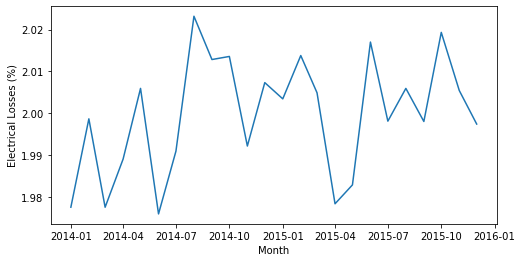

In [16]:
# Let's plot electrical losses by month
plt.figure(figsize = (8,4))
monthly_merge = el._merge_df.resample('MS').sum()
plt.plot((monthly_merge['corrected_energy'] - monthly_merge['energy_kwh']) / monthly_merge['corrected_energy'] * 100)
plt.xlabel('Month')
plt.ylabel('Electrical Losses (%)')

We see that electrical losses vary between 1.98 and 2.02%. This is a narrow range, but keep in mind the meter data for La Haute Borne was synthesized by NREL based on the SCADA data and sampling around a 2% electrical loss. Normally electrical losses using actual meter data would not be this consistent and would generally show seasonal trends.